# 5_Feature Selection & Fitting Model

1. 변수 선택 + a -> 최종 데이터셋 만들기  
2. 간단한 모델에 돌려보기 -> 다중 선형 회귀, 릿지 회귀(, k-최근접이웃 회귀, 분류나무) -> 최종 데이터셋 선정
3. 돌릴 수 있는 모델 공부해오기

**데이콘 평가 기준 : RMSE**  
mse : 실제값과 예측값의 차이를 제곱해서 평균한 것  
rmse : mse에서 루트를 씌운 값  
*두 값 모두 error이기 때문에 값이 작을수록 좋은 것 , r2adj (1에 가까워야 좋음) 랑 다름*

In [1]:
%matplotlib inline
import os
from pathlib import Path
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix, parallel_coordinates
import seaborn as sns
import matplotlib.pylab as plt
import warnings

In [2]:
train = pd.read_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/pre3_train")
train.set_index('id', inplace=True)
test = pd.read_csv("C:/Users/kimch/Desktop/229255_bus_riders_at_rush_hour_data/pre3_test")
test.set_index('id', inplace=True)

In [3]:
# DateTime Index랑 범주형 변수는 데이터셋에 저장이 안되는건가 다시 설정해줌
train["date"] = pd.to_datetime(train.date, format='%Y-%m-%d')
test["date"] = pd.to_datetime(test.date, format="%Y-%m-%d")

categorical = ["weather", "bus_route_class"]
train[categorical] = train[categorical].astype('category')
test[categorical] = test[categorical].astype('category')

In [4]:
# # 아래 변수들 삭제할까 했는데 삭제 안했을 때 rmse 점수 더 낮아져서 삭제 안하고 냅두기로 함
# # 지역변수 north만 남겨두기
# train = train.drop(columns=["region_other", "region_south", "region_west"])
# test = test.drop(columns=["region_other", "region_south", "region_west"])
# # 요일변수 삭제
# train = train.drop(columns=['dayofwk_mon', 'dayofwk_sat', 'dayofwk_sun', 'dayofwk_thur', 'dayofwk_tue', 'dayofwk_wed'])
# test = test.drop(columns=['dayofwk_mon', 'dayofwk_sat', 'dayofwk_sun', 'dayofwk_thur', 'dayofwk_tue', 'dayofwk_wed'])
# # 휴일변수 삭제
# train = train.drop(columns=['holiday_1'])
# test = test.drop(columns=['holiday_1'])

In [5]:
train

,date,bus_route_id,station_code,station_name,latitude,longitude,6~7_ride,7~8_ride,8~9_ride,9~10_ride,...,region_south,region_west,dayofwk_mon,dayofwk_sat,dayofwk_sun,dayofwk_thur,dayofwk_tue,dayofwk_wed,holiday_1,inout_out
id,,,,,,,,,,,,,,,,,,,,,
0,2019-09-01,4270000,344,제주썬호텔,33.48990,126.49373,0.000000,0.693147,1.098612,1.791759,...,0,0,0,0,0,0,0,1,0,1
1,2019-09-01,4270000,357,한라병원,33.48944,126.48508,0.693147,1.609438,1.609438,1.098612,...,0,0,0,0,0,0,0,1,0,1
2,2019-09-01,4270000,432,정존마을,33.48181,126.47352,0.693147,0.693147,0.000000,1.098612,...,0,0,0,0,0,0,0,1,0,1
3,2019-09-01,4270000,1579,제주국제공항(600번),33.50577,126.49252,0.000000,2.890372,1.945910,3.295837,...,0,0,0,0,0,0,0,1,0,0
4,2019-09-01,4270000,1646,중문관광단지입구,33.25579,126.41260,0.000000,0.000000,0.000000,0.000000,...,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
415418,2019-09-30,32820000,1129,한림환승정류장(한림리),33.41437,126.26336,1.609438,0.000000,0.000000,0.000000,...,0,1,0,0,0,1,0,0,0,0
415419,2019-09-30,32820000,1564,제주시외버스터미널,33.49946,126.51479,1.609438,0.000000,0.000000,0.000000,...,0,0,0,0,0,1,0,0,0,0
415420,2019-09-30,32820000,2322,해병부대,33.23100,126.26273,0.000000,0.000000,0.000000,0.000000,...,0,1,0,0,0,1,0,0,0,0


## Train -> Train, Valid

In [6]:
from sklearn.model_selection import train_test_split

In [8]:
# 우리에게 주어진 test셋은 말만 test셋이고 18~20_ride 컬럼이 없기 때문에 train -> train, valid, test로 나눠야함
# 파라미터튜닝할 때 train, valid, test로 나누고 오늘은 train, valid로만 나눔
X = train.drop(columns=["18~20_ride", "date", "station_name", "station_code"])  # date, station_name은 datetime, string이기에 빼줌
y = train["18~20_ride"]

# train : valild = 6: 4
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, shuffle=True, random_state=1)

## Feature Selection

In [9]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, BayesianRidge
import statsmodels.formula.api as sm

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score, BIC_score

### 후방 소거법 (backward elimination)

In [11]:
# 회귀모델 학습
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

# AIC score 반환, AIC 기준 변수 소거할지 말지 선택
def score_model(model, variables):
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = backward_elimination(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: bus_route_id, latitude, longitude, 6~7_ride, 7~8_ride, 8~9_ride, 9~10_ride, 10~11_ride, 11~12_ride, 6~7_takeoff, 7~8_takeoff, 8~9_takeoff, 9~10_takeoff, 10~11_takeoff, 11~12_takeoff, weather, bus_route_class, region_north, region_other, region_south, region_west, dayofwk_mon, dayofwk_sat, dayofwk_sun, dayofwk_thur, dayofwk_tue, dayofwk_wed, holiday_1, inout_out
Start: score=383296.66
Step: score=383296.66, remove None
['bus_route_id', 'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', 'weather', 'bus_route_class', 'region_north', 'region_other', 'region_south', 'region_west', 'dayofwk_mon', 'dayofwk_sat', 'dayofwk_sun', 'dayofwk_thur', 'dayofwk_tue', 'dayofwk_wed', 'holiday_1', 'inout_out']


In [12]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

               Mean Error (ME) : -0.0001
Root Mean Squared Error (RMSE) : 0.5191
     Mean Absolute Error (MAE) : 0.3499


### 전방 선택법 (forward selection)

In [13]:
# 회귀모델 학습
def train_model(variables):
    if len(variables)==0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

# AIC score 기준으로 선택할지 말지 결정
def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model ,best_variables = forward_selection(train_X.columns, train_model, score_model, verbose=True)

print(best_variables)

Variables: bus_route_id, latitude, longitude, 6~7_ride, 7~8_ride, 8~9_ride, 9~10_ride, 10~11_ride, 11~12_ride, 6~7_takeoff, 7~8_takeoff, 8~9_takeoff, 9~10_takeoff, 10~11_takeoff, 11~12_takeoff, weather, bus_route_class, region_north, region_other, region_south, region_west, dayofwk_mon, dayofwk_sat, dayofwk_sun, dayofwk_thur, dayofwk_tue, dayofwk_wed, holiday_1, inout_out
Start: score=534788.27, constant
Step: score=463223.98, add 11~12_ride
Step: score=431300.27, add 10~11_ride
Step: score=414718.17, add 9~10_ride
Step: score=404684.16, add 8~9_ride
Step: score=400560.38, add 8~9_takeoff
Step: score=396032.79, add 7~8_ride
Step: score=393114.19, add bus_route_class
Step: score=390865.19, add region_north
Step: score=389126.51, add 9~10_takeoff
Step: score=387676.24, add 6~7_ride
Step: score=386565.23, add bus_route_id
Step: score=385610.02, add 11~12_takeoff
Step: score=385008.36, add 10~11_takeoff
Step: score=384530.81, add 7~8_takeoff
Step: score=384218.87, add weather
Step: score=3

In [14]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

               Mean Error (ME) : -0.0001
Root Mean Squared Error (RMSE) : 0.5191
     Mean Absolute Error (MAE) : 0.3499


### 단계적 선택 방법 (stepwise regression)

In [15]:
best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=1)

print(best_variables)

Variables: bus_route_id, latitude, longitude, 6~7_ride, 7~8_ride, 8~9_ride, 9~10_ride, 10~11_ride, 11~12_ride, 6~7_takeoff, 7~8_takeoff, 8~9_takeoff, 9~10_takeoff, 10~11_takeoff, 11~12_takeoff, weather, bus_route_class, region_north, region_other, region_south, region_west, dayofwk_mon, dayofwk_sat, dayofwk_sun, dayofwk_thur, dayofwk_tue, dayofwk_wed, holiday_1, inout_out
Start: score=534788.27, constant
Step: score=463223.98, add 11~12_ride
Step: score=431300.27, add 10~11_ride
Step: score=414718.17, add 9~10_ride
Step: score=404684.16, add 8~9_ride
Step: score=400560.38, add 8~9_takeoff
Step: score=396032.79, add 7~8_ride
Step: score=393114.19, add bus_route_class
Step: score=390865.19, add region_north
Step: score=389126.51, add 9~10_takeoff
Step: score=387676.24, add 6~7_ride
Step: score=386565.23, add bus_route_id
Step: score=385610.02, add 11~12_takeoff
Step: score=385008.36, add 10~11_takeoff
Step: score=384530.81, add 7~8_takeoff
Step: score=384218.87, add weather
Step: score=3

In [16]:
# 결과는 전진, 후방, 단계적 다 똑같은 것 같음
regressionSummary(train_y, best_model.predict(train_X[best_variables]))


Regression statistics

               Mean Error (ME) : -0.0000
Root Mean Squared Error (RMSE) : 0.5220
     Mean Absolute Error (MAE) : 0.3516


In [17]:
regressionSummary(valid_y, best_model.predict(valid_X[best_variables]))


Regression statistics

               Mean Error (ME) : -0.0001
Root Mean Squared Error (RMSE) : 0.5191
     Mean Absolute Error (MAE) : 0.3499


## 변수 중요도  
위에 전진, 후진, 단계적으로 했을 때 그냥 제거되는 것 없이 다 가지고 하게 되는 것 같아서 (rmse가 그럴 때 더 낮긴 하지만..) 변수 중요도 살펴봄   
  
references : https://zephyrus1111.tistory.com/272

1. correlation : 중요한 설명변수라면 해당 변수는 반응변수와의 상관관계가 큼  
2. linear regression coefficient : 회귀계수의 절댓값이 클수록 해당 설명변수가 반응변수 예측값에 더 많은 영향력을 행사  
3. permutation importance : 테스트 셋의 각 변수값들을 재배열한 후 예측력이 얼마나 변하는지 알려주는 변수 중요도, 특정 변수가 예측력에 영향을 미치지 않는다면 특정 변수의 값들을 재배열하더라도 예측력이 크게 달라지지 않을 것

### correlation

In [9]:
corr = train.corr()

In [10]:
y_corr = corr[["18~20_ride"]].sort_values(by="18~20_ride",ascending=False)[1:]
y_corr

,18~20_ride
11~12_ride,0.500859
10~11_ride,0.484033
9~10_ride,0.471199
8~9_ride,0.435800
7~8_ride,0.356636
11~12_takeoff,0.286999
9~10_takeoff,0.281505
10~11_takeoff,0.279519
8~9_takeoff,0.265671
6~7_ride,0.237550


<BarContainer object of 28 artists>

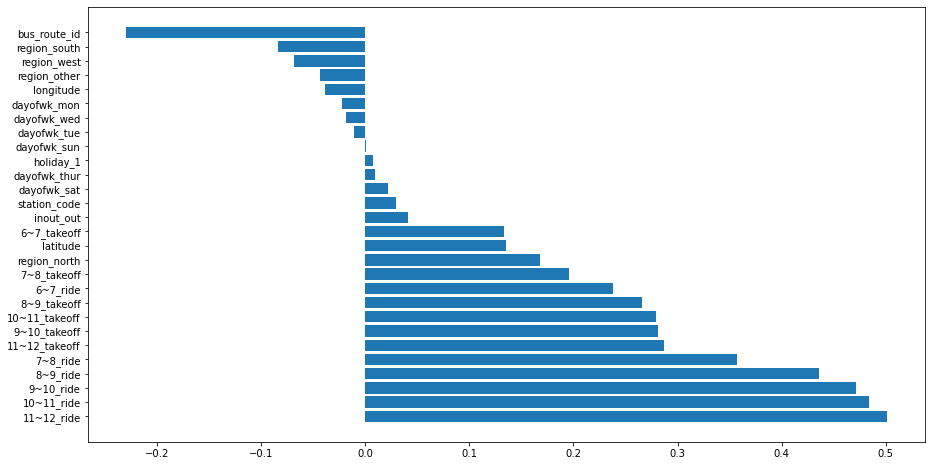

In [17]:
plt.figure(figsize=(15,8))
plt.barh(y_corr.index, y_corr["18~20_ride"])

상관계수 절댓값 0.1 이하 :   
station_code, dayofwk_sat, dayofwk_thur, holiday_1, dayorwk_sun, dayofwk_tue, dayofwk_wed, dayofwk_mon, longitude, region_other, region_west, region_south  
-> 상대적으로 중요하지 않다.  
-> dayofwk 모든 변수, region north 빼고 다 + station_code, longitude

### linear regression coefficient

In [18]:
lm = LinearRegression()
lm.fit(train_X, train_y)

lm_coef = pd.DataFrame({"Predictor" : train_X.columns, 'coefficient': lm.coef_})
lm_coef = lm_coef.sort_values(by="coefficient", ascending=False)

In [19]:
lm_coef.set_index("Predictor")

,coefficient
Predictor,
11~12_ride,2.678822e-01
10~11_ride,2.356397e-01
9~10_ride,1.902025e-01
8~9_ride,1.533986e-01
7~8_ride,1.120662e-01
6~7_ride,1.083274e-01
bus_route_class,9.583539e-02
region_north,9.162494e-02
8~9_takeoff,7.293620e-02


<BarContainer object of 29 artists>

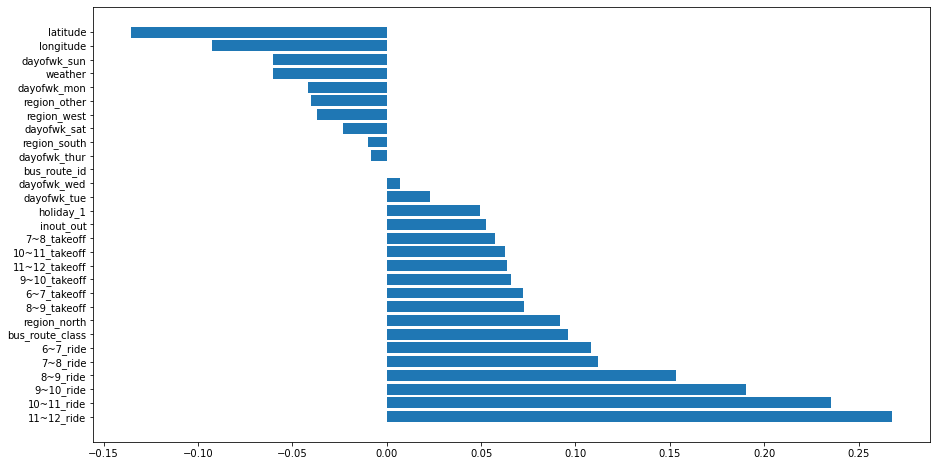

In [20]:
plt.figure(figsize=(15,8))
plt.barh(lm_coef.Predictor, lm_coef["coefficient"])

회귀계수 절댓값 0.05 이하 :  
dayofwk_mon, region_other, region_west, dayofwk_sat, region_south, dayofwk_thur, bus_route_id, dayofwk_wed, dayofwk_tue   
-> 상대적으로 중요하지 않음   
dayofwk sun 빼고 다, region north 빼고 다 + bus_route_id

### permutation importance

In [9]:
import eli5 
from eli5.sklearn import PermutationImportance

In [43]:
lr = LinearRegression()
lr.fit(train_X, train_y)

LinearRegression()

In [47]:
permu_lr = PermutationImportance(lr, scoring="neg_root_mean_squared_error", random_state=1).fit(valid_X, valid_y)
eli5.show_weights(permu_lr, top=29, feature_names=valid_X.columns.tolist())

Weight,Feature
0.0365 ± 0.0007,11~12_ride
0.0289 ± 0.0004,10~11_ride
0.0198 ± 0.0003,9~10_ride
0.0159 ± 0.0004,8~9_ride
0.0089 ± 0.0002,7~8_ride
0.0039 ± 0.0002,region_north
0.0037 ± 0.0002,bus_route_class
0.0034 ± 0.0002,6~7_ride
0.0027 ± 0.0002,8~9_takeoff
0.0027 ± 0.0002,bus_route_id


값이 클수록 중요한 변수  
-> latitude, dayofwk_mon, longitude, region_west, dayofwk_sat, inout_out, dayofwk_tue, region_other, region_south, dayofwk_thur, dayofwk_wed 상대적으로 중요하지 않음 
-> dayofwk sun 빼고 다, region north 빼고 다, + latitude, longitude, inout_out

**최종선택**  
-> region_west만 남기기 + dayofwk_sun만 남기기  
-> latitude, longitude 빼볼까 ?   
-> station_code, bus_route_id도 굳이인가 ?   

## Model Fitting

### <변수 중요도 고려한 것>

In [21]:
train.columns

Index(['date', 'bus_route_id', 'station_code', 'station_name', 'latitude',
       'longitude', '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride',
       '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff',
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride',
       'weather', 'bus_route_class', 'region_north', 'region_other',
       'region_south', 'region_west', 'dayofwk_mon', 'dayofwk_sat',
       'dayofwk_sun', 'dayofwk_thur', 'dayofwk_tue', 'dayofwk_wed',
       'holiday_1', 'inout_out'],
      dtype='object')

In [10]:
# 변수 중요도로 선택한 최종 모델
# fs1 : region_west, dayofwk_sun만 남긴 것
# fs2 : region_west, dayofwk_sun만 남기고 latitude, longitude 뺀 것
# fs3 : region_west, dayofwk_sun만 남기고 station_code, bus_route_id 뺀 것
# fs4 : region_west, dayofwk_sum만 남기고 latitude, longitude, station_code, bus_route_id 뺀 것
fs1 = ['bus_route_id', 'station_code', 'latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride',
       '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride',
       'weather', 'bus_route_class', 'region_north', 'dayofwk_sun', 'holiday_1', 'inout_out'] 
fs2 = ['bus_route_id', 'station_code', '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride',
       '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride',
       'weather', 'bus_route_class', 'region_north', 'dayofwk_sun', 'holiday_1', 'inout_out'] 
fs3 = ['latitude', 'longitude', '6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride',
       '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride',
       'weather', 'bus_route_class', 'region_north', 'dayofwk_sun', 'holiday_1', 'inout_out'] 
fs4 = ['6~7_ride', '7~8_ride', '8~9_ride', '9~10_ride', '10~11_ride', '11~12_ride', '6~7_takeoff', '7~8_takeoff', '8~9_takeoff', 
       '9~10_takeoff', '10~11_takeoff', '11~12_takeoff', '18~20_ride', 'weather', 'bus_route_class', 'region_north', 'dayofwk_sun', 'holiday_1', 'inout_out'] 

In [11]:
train1 = train[fs1]
train2 = train[fs2]
train3 = train[fs3]
train4 = train[fs4]

In [12]:
# train1
X1 = train1.drop(columns=["18~20_ride"])
y1 = train1["18~20_ride"]

train_X1, valid_X1, train_y1, valid_y1 = train_test_split(X1, y1, test_size=0.4, shuffle=True, random_state=1)

# train2
X2 = train2.drop(columns=["18~20_ride"])
y2 = train2["18~20_ride"]

train_X2, valid_X2, train_y2, valid_y2 = train_test_split(X2, y2, test_size=0.4, shuffle=True, random_state=1)

# train3
X3 = train3.drop(columns=["18~20_ride"])
y3 = train3["18~20_ride"]

train_X3, valid_X3, train_y3, valid_y3 = train_test_split(X3, y3, test_size=0.4, shuffle=True, random_state=1)

# train4
X4 = train4.drop(columns=["18~20_ride"])
y4 = train4["18~20_ride"]

train_X4, valid_X4, train_y4, valid_y4 = train_test_split(X4, y4, test_size=0.4, shuffle=True, random_state=1)

### 다중선형회귀

In [13]:
# train1
linearRegression = LinearRegression().fit(train_X1, train_y1)
regressionSummary(valid_y1, linearRegression.predict(valid_X1))


Regression statistics

               Mean Error (ME) : -0.0001
Root Mean Squared Error (RMSE) : 0.5193
     Mean Absolute Error (MAE) : 0.3499


In [26]:
# train2 
linearRegression = LinearRegression().fit(train_X2, train_y2)
regressionSummary(valid_y2, linearRegression.predict(valid_X2))


Regression statistics

               Mean Error (ME) : -0.0001
Root Mean Squared Error (RMSE) : 0.5195
     Mean Absolute Error (MAE) : 0.3499


In [27]:
# train3
linearRegression = LinearRegression().fit(train_X3, train_y3)
regressionSummary(valid_y3, linearRegression.predict(valid_X3))


Regression statistics

               Mean Error (ME) : -0.0002
Root Mean Squared Error (RMSE) : 0.5204
     Mean Absolute Error (MAE) : 0.3509


In [28]:
# train4
linearRegression = LinearRegression().fit(train_X4, train_y4)
regressionSummary(valid_y4, linearRegression.predict(valid_X4))


Regression statistics

               Mean Error (ME) : -0.0002
Root Mean Squared Error (RMSE) : 0.5206
     Mean Absolute Error (MAE) : 0.3507


### Ridge  
bayesianRidge로 돌림

In [30]:
warnings.filterwarnings('ignore')

In [33]:
# train1
bayesianRidge = BayesianRidge(normalize=True)
bayesianRidge.fit(train_X1, train_y1)
regressionSummary(valid_y1, bayesianRidge.predict(valid_X1))


Regression statistics

               Mean Error (ME) : -0.0001
Root Mean Squared Error (RMSE) : 0.5193
     Mean Absolute Error (MAE) : 0.3499


In [34]:
# train2
bayesianRidge = BayesianRidge(normalize=True)
bayesianRidge.fit(train_X2, train_y2)
regressionSummary(valid_y2, bayesianRidge.predict(valid_X2))


Regression statistics

               Mean Error (ME) : -0.0001
Root Mean Squared Error (RMSE) : 0.5195
     Mean Absolute Error (MAE) : 0.3499


In [35]:
# train3
bayesianRidge = BayesianRidge(normalize=True)
bayesianRidge.fit(train_X3, train_y3)
regressionSummary(valid_y3, bayesianRidge.predict(valid_X3))


Regression statistics

               Mean Error (ME) : -0.0002
Root Mean Squared Error (RMSE) : 0.5204
     Mean Absolute Error (MAE) : 0.3509


In [36]:
# train4
bayesianRidge = BayesianRidge(normalize=True)
bayesianRidge.fit(train_X4, train_y4)
regressionSummary(valid_y4, bayesianRidge.predict(valid_X4))


Regression statistics

               Mean Error (ME) : -0.0002
Root Mean Squared Error (RMSE) : 0.5206
     Mean Absolute Error (MAE) : 0.3507


사실 큰 차이는 아니지만 전체변수 다 돌릴때가 제일 rmse 낮긴 함.  
그정도 차이(0.0002, 0.0004)면 train1이나 train2로 돌려도 될 것 같긴 하다. 사실 train3, train4도 차이는 없는데 0.51 -> 0.52 돼서

### <변수중요도 고려하지 않은 것 -> 변수선택기법 결과 모든 변수로 다 돌림>

### 다중선형회귀

In [17]:
linearRegression = LinearRegression().fit(train_X, train_y)
regressionSummary(valid_y, linearRegression.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.0001
Root Mean Squared Error (RMSE) : 0.5191
     Mean Absolute Error (MAE) : 0.3499


### Ridge

In [14]:
# Ridge
ridge = Ridge(normalize=True, alpha=1)
ridge.fit(train_X, train_y)
regressionSummary(valid_y, ridge.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.0001
Root Mean Squared Error (RMSE) : 0.5315
     Mean Absolute Error (MAE) : 0.3792


In [15]:
# BayesianRidge
bayesianRidge = BayesianRidge(normalize=True)
bayesianRidge.fit(train_X, train_y)
regressionSummary(valid_y, bayesianRidge.predict(valid_X))


Regression statistics

               Mean Error (ME) : -0.0001
Root Mean Squared Error (RMSE) : 0.5191
     Mean Absolute Error (MAE) : 0.3499


In [16]:
# 반복적으로 시행해서 penalty parameter 결정해줌
print('Bayesian Ridge chosen regularization :', bayesianRidge.lambda_ / bayesianRidge.alpha_)
print(bayesianRidge.coef_)

Bayesian Ridge chosen regularization : 0.00043854653030155316
[-9.49641967e-09 -1.34313989e-01 -9.27999734e-02  1.08333453e-01
  1.12065629e-01  1.53385770e-01  1.90176784e-01  2.35578557e-01
  2.67797018e-01  7.22522209e-02  5.71287451e-02  7.29329759e-02
  6.56424148e-02  6.24379680e-02  6.35670802e-02 -6.01972155e-02
  9.58419604e-02  9.13420121e-02 -4.05326090e-02 -1.02048217e-02
 -3.70192882e-02 -4.17937752e-02 -2.30621078e-02 -6.01801154e-02
 -8.11150135e-03  2.30480640e-02  6.88002673e-03  4.92605222e-02
  5.23370631e-02]


## 모델

1. LinearRegression
2. Lasso (L1 규제) : 예측 영향력이 적은 feature의 회귀계수를 0으로 만든다 (=> feature selection 기능)
3. LassoCV
4. Ridge (L2 규제) : 상대적으로 큰 회귀계수 값의 예측 영향을 감소시키기 위해 회귀 계수값을 더 작게 만드는 규제모델
5. bayesianRidge
6. ElasticNet : L1, L2 규제 결합한 모델, feature 수 많은 데이터셋에 적용
7. *Polynomial Regression : 다항 회귀 -> 18~20_ride랑 모든 변수 산점도 그리고 2차, 3차 변수 추가? 패키지는 없나* 
8. **Ensemble**  
randomforestregressor, lgbmregressor, xgboostregressor, gradientbosstingregressor  

## 다음주

각자 간단한모델 1, 앙상블 모델 1 공부 및 파라미터 튜닝 